In [1]:
from datetime import datetime
import pandas as pd
import numpy as np;
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import sklearn as sklearn
from sklearn import linear_model, model_selection
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier


/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def space(n=1):
    print("\n" * n)

def analyze_feature(df, name, display):
    col = df[name];
    col_size = col.size;
    col_ok = col.notna().sum();
    col_nan = col.isna().sum();
    proc_ok = col_ok * 100 / col_size;
    proc_nan =  col_nan * 100 / col_size;
    
    if(display):
        print("Name: %s" % name)
        print("Type: %s" % str(col.dtype))
        print("OK: %i | NA: %i | OK_PROC: %.2f | NA_PROC: %.2f" % (col_ok, col_nan, proc_ok, proc_nan))
    return {
        "name": name,
        "type": col.dtype,
        "col_size": col_size,
        "col_ok": col_ok,
        "col_nan": col_nan,
        "proc_ok": proc_ok,
        "proc_nan": proc_nan
    }

def analyze_values(df):
    r = {
        "cols_0": [],
        "cols_max25": [],
        "cols_max50": [],
        "cols_max75": [],
        "cols_max100": [],
        "cols_100": []
    }
    
    for name in df.columns:
        result = analyze_feature(df, name, False);
        proc_ok = result["proc_ok"];

        if proc_ok == 0:
            r["cols_0"].append(name)
        elif proc_ok < 25:
            r["cols_max25"].append(name)
        elif proc_ok < 50:
            r["cols_max50"].append(name)
        elif proc_ok < 75:
            r["cols_max75"].append(name)
        elif proc_ok < 100:
            r["cols_max100"].append(name)
        else:
            r["cols_100"].append(name)
    
    return r

def print_avalues(r, verbose, headline=""):
    print(headline)
    for (k,v) in r.items():
        print(k, len(v))
        if verbose:
              print(v)
                
def analyze_types(df):
    r = {}
    
    for name in df.columns:
        t = str(df[name].dtype)
        if t in r.keys():
            r[t].append(name)
        else: 
            r[t] = [name]
            
    return r

def find_date_columns(df, obj_cols):
    r = []
    for col in obj_cols:
        if len(df[col].unique()) > 45:
            r.append(col)
    return r

def transform_boolean(df, column):
    return df[column].replace([True], 1).replace([False], 0).astype(int)
                                          
def get_num_cols(data):
    r = []
    t = analyze_types(data)
    r.extend(t["int64"])
    r.extend(t["float64"])
    return r
                                                                    
def get_categ_cols(data):
    return analyze_types(data)["object"]                                                                  

In [3]:
### LOAD DATA
CSV_IN_PATH = "/Users/ion/Desktop/msc/mlaas/notebooks/data.csv"
data = pd.read_csv(CSV_IN_PATH)
print(data.shape)



(10689, 135)


In [4]:
### USELESS COLUMNS
useless_columns = [
    "County",
    "Caen",
    "AFC cl",
    "AFC deb",
    "Code",
    "Nr_deb",
    "Nr_cl",
    "Apartment",
    "PrimireDocLaF_COM",
    "PrimireCS_Semnate",
    "TransmitereCS",
    "PrimireInsusireGrup",
    "SolicitInfoRetea1",
    "PrimireInfoRetea1",
    "SolicitInfoRetea2",
    "PrimireInfoRetea2",
    "SolicitareLimita",
    "RespRisc",
    "Data lim fin",
    "Valab lim fin",
    "Data lim cr",
    "Valab lim cr",
    "IdAsigurator",
    "DataExpirare",
    "Grup_limite"
];

In [5]:
### FIX TYPOS/SYNONYMS
data['TipProdus'] = data['TipProdus'] \
    .replace(['ADMsiCOL'], 'Combinate') \
    .replace(['De Export'], "Export");

data['TipAnaliza'] = data['TipAnaliza'] \
    .replace(['Solicitare noua'], 'new') \
    .replace(['memo/notificari/alte acte aditionale'], 'extra_files') \
    .replace(['Acte aditionale/notificari'], 'extra_files') \
    .replace(['Prelungire facilitate'], 'extension') \
    .replace(['Debitori noi pe contract in derulare'], 'new_debtors') \
    .replace(['Debitori noi'], 'new_debtors') \
    .replace(['Majorare plafon'], 'increase') \
    .replace(['Opinie factorabilitate'], 'query');

data['Status Recom'] = data['Status Recom'] \
    .replace(['functiune;'], 'functiune') \
    .replace(['functiune;fuziune prin absorbtie;'], 'functiune') \
    .replace(['este sub incidenta Legii nr. 85/2006;'], 'insolventa') \
    .replace(['insolventa;este sub incidenta legii 85/2014;'], 'insolventa') \
    .replace(['reorganizare judiciara;este sub incidenta legii 85/2014;'], 'insolventa') \
    .replace(['dizolvare;faliment;insolventa;este sub incidenta Legii nr. 85/2006;'], 'insolventa') \
    .replace(['faliment;este sub incidenta Legii nr. 85/2006;'], 'insolventa') \
    .replace(['reorganizare judiciara; este sub incidenta Legii nr. 85/2006;'], 'insolventa') \
    .replace(['reorganizare judiciara;este sub incidenta Legii nr. 85/2006;'], 'insolventa') \
    .replace(['este sub incidenta legii 85/2014;'], 'insolventa') \
    .replace(['faliment; este sub incidenta Legii nr. 85/2006; lichidare;'], 'insolventa') \
    .replace(['faliment;este sub incidenta legii 85/2014;'], 'insolventa') \
    .replace(['interdictia initierii procedurii de dizolvare sau lichidare cf. Legii 286/2009, Legii 135/2010;functiune;'], 'insolventa')

In [6]:
### ANALYZE MISSING VALUES
print("BEFORE CLEANUP")
missing_val_report = analyze_values(data)
print_avalues(missing_val_report, False, "> Missing values/column report")
space();

## ANALYZE DATA TYPES
type_report = analyze_types(data)
print_avalues(type_report, False, "> Columns/type report")
space()

## FIND DATE
date_cols = find_date_columns(data, type_report["object"])
print("> Date cols", len(date_cols))
space()

BEFORE CLEANUP
> Missing values/column report
cols_0 10
cols_max25 15
cols_max50 3
cols_max75 66
cols_max100 22
cols_100 19


> Columns/type report
object 43
int64 5
float64 86
bool 1


> Date cols 21




In [7]:
### CLEANUP
data.drop(columns=useless_columns, axis=1, inplace=True, errors="ignore")
print("> Data after droping useless cols:", data.shape)
space()

data.dropna(axis=1, how="all", inplace=True)
print("> Data after removing EMPTY cols:", data.shape)
space()

data.drop(missing_val_report["cols_max25"], axis=1, inplace=True, errors="ignore")
data.drop(missing_val_report["cols_max50"], axis=1, inplace=True, errors="ignore")
print("> Data after removing >50% empty cols:", data.shape)
space()

> Data after droping useless cols: (10689, 110)


> Data after removing EMPTY cols: (10689, 100)


> Data after removing >50% empty cols: (10689, 88)




In [8]:
### ANALYZE MISSING VALUES
print("AFTER CLEANUP")
missing_val_report = analyze_values(data)
print_avalues(missing_val_report, False, "> Missing values/column report")
space();

## ANALYZE DATA TYPES
type_report = analyze_types(data)
print_avalues(type_report, False, "> Columns/type report")
space()

## FIND DATE
date_cols = find_date_columns(data, type_report["object"])
print("> Date cols", len(date_cols))
space()

AFTER CLEANUP
> Missing values/column report
cols_0 0
cols_max25 0
cols_max50 0
cols_max75 62
cols_max100 15
cols_100 11


> Columns/type report
object 19
float64 68
bool 1


> Date cols 4




In [9]:
### TIME LABEL
time_label_cols = ["TransmitereDocLaF_RISC", "FinalizareNotaAnaliza"]

if set(time_label_cols).issubset(data.columns):
    print("> Before removing NAs")
    analyze_feature(data, "TransmitereDocLaF_RISC", True)
    space()

    analyze_feature(data, "FinalizareNotaAnaliza", True)
    space()
    
    data.dropna(subset=time_label_cols, inplace=True)
    
    print(">After removing NAs")
    analyze_feature(data, "TransmitereDocLaF_RISC", True)
    space()

    analyze_feature(data, "FinalizareNotaAnaliza", True)
    space()
    
    data["TransmitereDocLaF_RISC"] = pd.to_datetime(data["TransmitereDocLaF_RISC"])
    data["FinalizareNotaAnaliza"] = pd.to_datetime(data["FinalizareNotaAnaliza"])
    data["Time"] = data["FinalizareNotaAnaliza"] - data["TransmitereDocLaF_RISC"]
    data["Time"] = data["Time"].astype('timedelta64[D]').astype('int')
    data = pd.DataFrame(data[data["Time"] >= 0])
    data.drop(time_label_cols, axis=1, inplace=True)
else:
    print("TIME already converted!")

analyze_feature(data, "Time", True)
space()

> Before removing NAs
Name: TransmitereDocLaF_RISC
Type: object
OK: 8047 | NA: 2642 | OK_PROC: 75.28 | NA_PROC: 24.72


Name: FinalizareNotaAnaliza
Type: object
OK: 5733 | NA: 4956 | OK_PROC: 53.63 | NA_PROC: 46.37


>After removing NAs
Name: TransmitereDocLaF_RISC
Type: object
OK: 5605 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00


Name: FinalizareNotaAnaliza
Type: object
OK: 5605 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00


Name: Time
Type: int64
OK: 5602 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00




In [10]:
### APPROVED LABEL

limit_label_done = False;
if not limit_label_done:
    data["Limit"] = data["Limita fin"]
    data.drop(["Limita fin"], axis=1, inplace=True)
    data["Limit"] = data["Limit"] > 0
    data["Limit"] = transform_boolean(data, "Limit")
    limit_label_done = True
    
analyze_feature(data, "Limit", True)
space()

Name: Limit
Type: int64
OK: 5602 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00




In [11]:
### CONVERT BOOLEANS
boolean_cols_done = False;
fake_bool_cols = ["BankCustomer", "CuAvizRisc", "Rezolvat"]

if not boolean_cols_done:
    if len(type_report["bool"]) > 0:
        for col in type_report["bool"]:
            analyze_feature(data, col, True)
            data[col] = transform_boolean(data, col)
            analyze_feature(data, col, True)
    
    for col in fake_bool_cols:
        analyze_feature(data, col, True)
        data[col] = transform_boolean(data, col)
        analyze_feature(data, col, True)
        
    boolean_cols_done = True;
space()

Name: BankCustomer
Type: bool
OK: 5602 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Name: BankCustomer
Type: int64
OK: 5602 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Name: BankCustomer
Type: int64
OK: 5602 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Name: BankCustomer
Type: int64
OK: 5602 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Name: CuAvizRisc
Type: object
OK: 5602 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Name: CuAvizRisc
Type: int64
OK: 5602 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Name: Rezolvat
Type: object
OK: 5602 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Name: Rezolvat
Type: int64
OK: 5602 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00




In [12]:
## TRANSFORM DATES

type_report = analyze_types(data)
date_cols = find_date_columns(data, type_report["object"])
data.dropna(how="any", subset=date_cols, inplace=True)

print("> Date cols", len(date_cols), date_cols)
space()

now = pd.to_datetime("now")
for col in date_cols:
    analyze_feature(data, col, True)
    data[col] = pd.to_datetime(data[col])
    data[col] = now - data[col]
    data[col] = data[col].astype('timedelta64[Y]').astype('int')

date_cols = []
space()

type_report = analyze_types(data)
print_avalues(type_report, False, "> Columns/type report after data transformation")
space()
print("> Shape after data transformation", data.shape)

> Date cols 2 ['activare_cont', 'Data Infiintare']


Name: activare_cont
Type: object
OK: 5578 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Name: Data Infiintare
Type: object
OK: 5578 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00


> Columns/type report after data transformation
object 13
float64 67
int64 7


> Shape after data transformation (5578, 87)


In [13]:
## CATEGORICAL

categ_done = False
missing_vals_categ = []

if not categ_done:
    for col in type_report["object"]:
        a = analyze_feature(data, col, False)
        if a["col_nan"] > 0:
            missing_vals_categ.append(col)
            print(a)
            print(data[col].unique())
            space()
    data.dropna(how="any", subset=missing_vals_categ, inplace=True)
    categ_done = True
    
print("> Shape after categ. transformation", data.shape)

{'name': 'TipProdus', 'type': dtype('O'), 'col_size': 5578, 'col_ok': 5500, 'col_nan': 78, 'proc_ok': 98.60164933667981, 'proc_nan': 1.3983506633201865}
['Intern' 'Export' 'Reverse' 'Import' 'Combinate' nan]


{'name': 'TipAnaliza', 'type': dtype('O'), 'col_size': 5578, 'col_ok': 5573, 'col_nan': 5, 'proc_ok': 99.91036213696665, 'proc_nan': 0.08963786303334528}
['extension' 'new_debtors' 'extra_files' 'increase' 'new' 'query' nan]


> Shape after categ. transformation (5495, 87)


In [14]:
## DROP DUPLICATES
data.drop_duplicates(inplace=True)
type_report = analyze_types(data)

print_avalues(type_report, False, "> Columns/type report after data transformation")
space()
print("> Shape after drop duplicates", data.shape)

> Columns/type report after data transformation
object 13
float64 67
int64 7


> Shape after drop duplicates (5178, 87)


In [15]:
## SPLIT THE DATA IN CATEG AND NUM
num_col = get_num_cols(data)
cat_col = get_categ_cols(data)

In [16]:
## SCALE NUMERIC DATA
num_col.remove("Time")
num_col.remove("Limit")

num_scaling = False
filled_cols = []
if not num_scaling:
    for col in num_col:
        a = analyze_feature(data, col, False)
        data[col] = data[col].apply(lambda x: round(x, 2))
        if a["proc_nan"] > 0:
            mean = round(data[col].mean(), 2)
            data[col] = data[col].fillna(mean)
            filled_cols.append(col)
        scaler = MinMaxScaler();
        data[[col]] = scaler.fit_transform(data[[col]])
    num_scaling = True
else:
    print("Scaling already done")

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return sel

In [17]:
## CORRELATION MATRIX, top 10
print(data.corr()["Limit"].sort_values(ascending=False).head(10))
space()
print(data.corr()["Time"].sort_values(ascending=False).head(10))

Limit                                                                     1.000000
DATORII: SUMELE CARE TREBUIE PLATITE INTR-O PERIOADA MAI MARE DE UN AN    0.565576
CHELTUIELI TOTALE                                                         0.563593
VENITURI TOTALE                                                           0.532473
Avansuri incasate in contul comenzilor                                    0.526246
Sold_Aprobat                                                              0.431430
Cheltuieli privind dobanzile                                              0.404286
Limita cr                                                                 0.393699
CifraAf                                                                   0.291046
ACTIVE IMOBILIZATE                                                        0.258701
Name: Limit, dtype: float64


Time                                                                1.000000
Rezolvat                                                       

In [18]:
## ENCODE CATEG. DATA
cat_encoded = False

if not cat_encoded:
    for col in cat_col:
        a = analyze_feature(data, col, True)
        label_encoder = LabelEncoder()
        encoded = label_encoder.fit_transform(data[col])
        data[col] = encoded
        # joblib.dump(label_encoder, "time_encoder_for_" + column)
        print(col, label_encoder.classes_, "\n")

        # Setup hot encoder and save
        one_hot_encoder = OneHotEncoder(categories='auto')
        hot_encoded = one_hot_encoder.fit_transform(data[[col]]).toarray()
        hot_encoded_df = pd.DataFrame(hot_encoded, columns=label_encoder.classes_, dtype=int)

        # Rebuild data
        data = data.drop(columns=[col]).reset_index(drop=True)
        hot_encoded_df = hot_encoded_df.reset_index(drop=True)
        data =  pd.concat([data, hot_encoded_df], axis=1)
    cat_encoded = True
else:
    print("Features already encoded")

Name: tip1
Type: object
OK: 5178 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
tip1 ['export' 'intern'] 

Name: tip2
Type: object
OK: 5178 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
tip2 ['cu regres' 'fara regres'] 

Name: Val
Type: object
OK: 5178 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Val ['EUR' 'GBP' 'RON'] 

Name: CF
Type: object
OK: 5178 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
CF ['CF' 'CFAC' 'EH' 'NOCF'] 

Name: Tip client
Type: object
OK: 5178 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Tip client ['CIB' 'NCORP' 'NMED' 'NSME' 'R'] 

Name: GTB
Type: object
OK: 5178 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
GTB ['D' 'N'] 

Name: Grup_fdb
Type: object
OK: 5178 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
Grup_fdb ['ACA' 'BAI' 'BRA' 'CLU' 'CON' 'CRA' 'DOR' 'FACT' 'GNE' 'IAS' 'MUR' 'NON'
 'PIA' 'PIT' 'PLO' 'REV' 'SIB' 'SMC' 'TIM' 'UNI' 'VAL'] 

Name: TipProdus
Type: object
OK: 5178 | NA: 0 | OK_PROC: 100.00 | NA_PROC: 0.00
TipProdus ['Combinate' 'Export' 'Import' 'Intern' 'Reverse'] 

Nam

In [19]:
print("> Shape after category encoding", data.shape)

> Shape after category encoding (5178, 135)


In [20]:
features = data.drop(["Time", "Limit"], axis=1);
time_label = data["Time"];
limit_label = data["Limit"];

rejected = data[data["Limit"] == 0]
accepted = data[data["Limit"] == 1].sample(1500)
class_data = pd.concat([rejected, accepted])
cfeatures = class_data.drop(["Time", "Limit"], axis=1);
climit_label = class_data["Limit"];

In [21]:
### FEATURE SELECTION
USE_FS = False;

if USE_FS:
    clf = ExtraTreesClassifier(n_estimators=100, criterion="entropy")
    clf = clf.fit(features, time_label)
    model = SelectFromModel(clf, prefit=True)
    features_new = model.transform(features)
    print(features_new.shape)

    cols = features.columns
    selected_cols = []
    i = 0;
    for f in model.get_support():
        if f:
            selected_cols.append(cols[i])
        i = i + 1;
    
    features = features[selected_cols]
    print("Selected:", selected_cols)
    features.shape

[8.31245506 8.98022408 8.87358088 8.41322222 9.50608287 8.04859918
 7.73669157 8.41218327 9.2025272  8.71086497]


CV RMSE Mean: 8.619643130146226
CV STDEV: 0.5112789874535
TEST RMSE 9.283863663793312


Text(0.5, 1.0, 'ROC Curve of kNN')

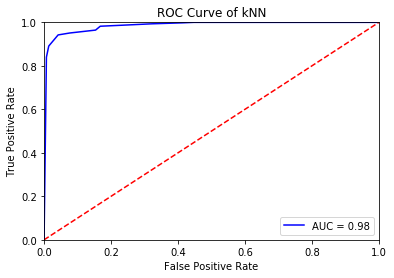

In [22]:
### KNN

### Regressor
train_x, test_x, train_y, test_y = train_test_split(features, time_label, test_size=0.3, random_state=42)

knn_reg = KNeighborsRegressor(algorithm='auto', n_neighbors=5, weights='distance')
scores = cross_val_score(knn_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=10)

rmse_scores = np.sqrt(-scores)
print(rmse_scores)
space()
print("CV RMSE Mean:", rmse_scores.mean())
print("CV STDEV:", rmse_scores.std())

knn_reg.fit(train_x, train_y)
test_p = knn_reg.predict(test_x)
test_rmse = mean_squared_error(test_y, test_p) ** 0.5
print("TEST RMSE", test_rmse)

### Classifier
train_x, test_x, train_y, test_y = train_test_split(cfeatures, climit_label, test_size=0.3, random_state=42)

knn_reg = KNeighborsClassifier(n_neighbors=10)
knn_reg.fit(train_x, train_y)
scores = knn_reg.predict_proba(test_x)

knn_fpr, knn_tpr, threshold = roc_curve(test_y, scores[:, 1])
roc_auc_knn = auc(knn_fpr, knn_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(knn_fpr, knn_tpr, 'b', label = 'AUC = %0.2f' % roc_auc_knn)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')

[5.721421   5.41805053 5.17125754 5.9677956  5.00878584 5.92267012
 6.07331674 4.47848065 7.32695089 5.60170393 5.47132754 4.83328723
 4.25946986 5.26007028 5.69740607 5.72214289 6.19907154 5.17664784
 5.19538566 5.33775391]


CV RMSE Mean: 5.49214978251546
CV STDEV: 0.6466892827550477
TEST RMSE 6.385050725784166


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0.5, 1.0, 'ROC Curve of kNN')

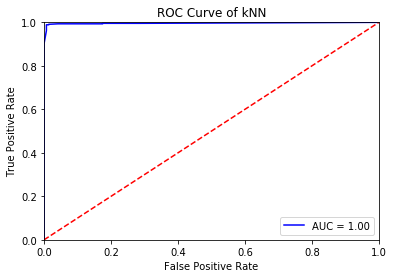

In [23]:
### Random Forest

### Regressor
train_x, test_x, train_y, test_y = train_test_split(features, time_label, test_size=0.3, random_state=42)

rf_reg = RandomForestRegressor(bootstrap=False, max_depth=20, max_features=30, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
scores = cross_val_score(rf_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=20)

rmse_scores = np.sqrt(-scores)
print(rmse_scores)
space()
print("CV RMSE Mean:", rmse_scores.mean())
print("CV STDEV:", rmse_scores.std())

rf_reg.fit(train_x, train_y)
test_p = rf_reg.predict(test_x)
test_rmse = mean_squared_error(test_y, test_p) ** 0.5
print("TEST RMSE", test_rmse)

### Classifier
train_x, test_x, train_y, test_y = train_test_split(cfeatures, climit_label, test_size=0.3, random_state=42)

knn_reg = RandomForestClassifier()
knn_reg.fit(train_x, train_y)
scores = knn_reg.predict_proba(test_x)

rf_fpr, rf_tpr, threshold = roc_curve(test_y, scores[:, 1])
roc_auc_rf = auc(rf_fpr, rf_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(rf_fpr, rf_tpr, 'b', label = 'AUC = %0.2f' % roc_auc_rf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')

[5.21032769 4.77067977 5.33682893 5.82525984 4.04297321 5.18720025
 5.7417651  4.35065546 7.55505577 5.3335942  4.75741225 4.21655519
 3.9146421  5.97642457 5.08084077 5.21489566 5.89247645 4.93083443
 5.2584456  5.18357132]


CV RMSE Mean: 5.189021927761529
CV STDEV: 0.7904966050947944
TEST RMSE 4.364770454852243


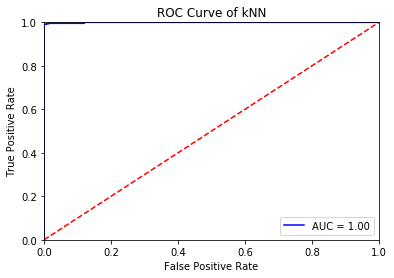

In [29]:
##### LGBM

### REGRESSOR
train_x, test_x, train_y, test_y = train_test_split(features, time_label, test_size=0.3, random_state=42)

lgbm_reg = LGBMRegressor(
    num_leaves=50,
    n_estimators=200,
    max_depth="10")
scores = cross_val_score(lgbm_reg, train_x, train_y, scoring="neg_mean_squared_error", cv=20)

rmse_scores = np.sqrt(-scores)
print(rmse_scores)
space()
print("CV RMSE Mean:", rmse_scores.mean())
print("CV STDEV:", rmse_scores.std())

lgbm_reg.fit(train_x, train_y)
test_p = lgbm_reg.predict(features)
test_rmse = mean_squared_error(test_p, time_label) ** 0.5
print("TEST RMSE", test_rmse)

### Classifier
train_x, test_x, train_y, test_y = train_test_split(cfeatures, climit_label, test_size=0.3, random_state=42)

knn_reg = LGBMClassifier()
knn_reg.fit(train_x, train_y)
scores = knn_reg.predict_proba(test_x)

lgb_fpr, lgb_tpr, threshold = roc_curve(test_y, scores[:, 1])
roc_auc_lgb = auc(lgb_fpr, lgb_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(lgb_fpr, lgb_tpr, 'b', label = 'AUC = %0.2f' % roc_auc_lgb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

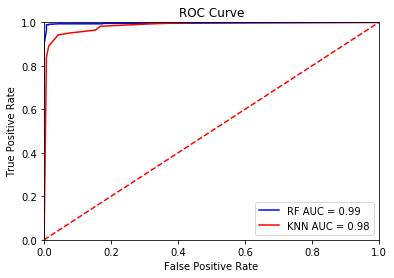

In [25]:
plt.title('Receiver Operating Characteristic')
plt.plot(rf_fpr, rf_tpr, 'b', label = 'RF AUC = %0.2f' % 0.99)
plt.plot(knn_fpr, knn_tpr, 'r', label = 'KNN AUC = %0.2f' % 0.98)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.savefig("/Users/ion/Desktop/msc/mlaas/notebooks/roc.png")

In [26]:
data["Time"].mean()

15.979335650830436